# **Regression Diagnostics of Multiple Linear Regression using the Example of the Dataset "*cacao.csv*"**

## Installing and Loading Libraries

Before we can begin with multiple linear regression, we need to install necessary libraries. Libraries are loaded as needed for the first time.

First, we update the package installer pip and then install the libraries numpy, pandas, matplotlib, scikit-learn, seaborn, and statsmodels.

In [8]:
# Update package installer

!python -m pip install --upgrade pip

# Install libraries

%pip install numpy >nul & pip install pandas >nul & pip install matplotlib >nul & pip install scikit-learn >nul & pip install seaborn >nul & pip install statsmodels >nul & pip install requests >nul

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Reset environment

%reset -f

## Building the Model

We do not want to optimize the model at this point; instead, we want to take a closer look at the diagnostics that need to be examined and interpret the results of the model diagnostics.

First, we need to create the model and load the data.

For this, we use "stem_diameter" as the dependent variable and all other variables as predictors.

In [17]:
import pandas as pd
import statsmodels.api as sm

url = "https://raw.githubusercontent.com/reyar/Statsomat/master/cacao.csv"
df = pd.read_csv(url)

y = df['stem_diameter']
x = df.drop('stem_diameter', axis=1) # axis = 1 to look at columns instead of rows
x = sm.add_constant(x)
model = sm.OLS(y, x).fit() # train the model


# **Regression Diagnostics**

The model was developed under certain assumptions. To examine these, we conduct specific diagnostics. These diagnostics ensure that the assumptions of the model have not been violated.

The following aspects are examined:

1. Outliers

2. High-Leverage Points

3. Non-Linearity

4. Heteroscedasticity

5. Correlation of Error Terms

6. Normality of Residuals

7. Collinearity of Predictors

___

## 1. Outliers

Outliers are data points that differ greatly from the expected value of the model. In order to detect outliers studentized residuals can be used.

A rule of thumb for the cut off value is $\pm$ 3, which means that values lower than -3 or bigger than 3 are considered as outliers.

In [140]:
import numpy as np
from statsmodels.stats.outliers_influence import OLSInfluence

influence = OLSInfluence(model)
studentized_residuals = influence.resid_studentized_internal
cutoff_stud_res = 3

print(studentized_residuals[np.abs(studentized_residuals) > cutoff_stud_res])

27    3.148621
dtype: float64


We can see that data point 27 has a absolut studentized residual larger than 3, so we consider it as an outlier. Plotting the studentized residuals can help visualizing this.

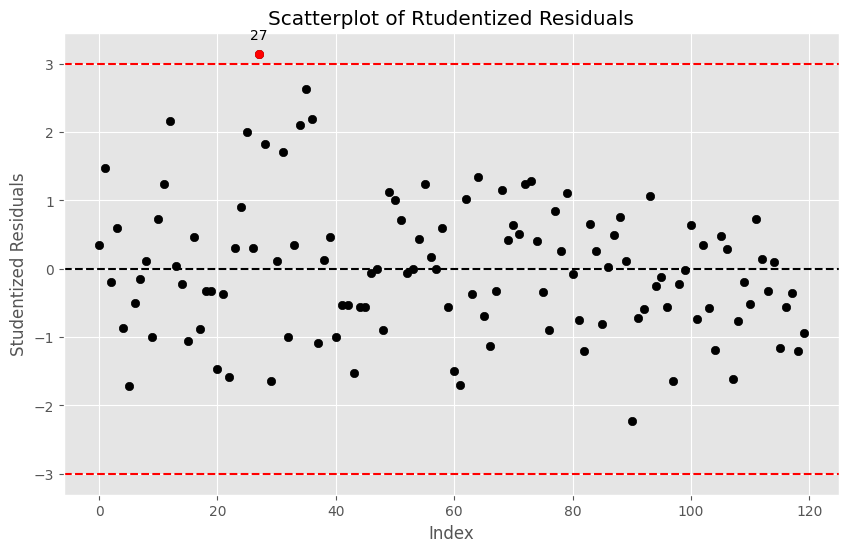

In [54]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.figure(figsize=(10, 6))
plt.scatter(range(len(studentized_residuals)), studentized_residuals, color='black')

outliers = np.abs(studentized_residuals) > cutoff_stud_res
plt.scatter( np.arange(len(studentized_residuals))[outliers], studentized_residuals[outliers], color='red')

for i in np.where(outliers)[0]:
    plt.annotate(i, (i, studentized_residuals[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=cutoff_stud_res, color='r', linestyle='--')
plt.axhline(y=-cutoff_stud_res, color='r', linestyle='--')

plt.title('Scatterplot of Rtudentized Residuals')
plt.xlabel('Index')
plt.ylabel('Studentized Residuals')
plt.show()

**Description of the Plot**

The x-axis shows the indeces of the data points, whereas the y-axis shows the value of the studentized residuals of those data points.

The black dashed line shows the zero-line. Therefore, the red dashed lines show the cut off value of $\pm$ 3. 

**Interpretation**

Values outside of this range are marked red. Those values are the outliers. In this data set, datapoint 27 is considered as an outlier.

___

## 2. High-Leverage/-Influence Points

### 2.1 High-Leverage Points

High-leverage points are data points that have a high influence on the impact regression coefficients and therefore on the model.

In [134]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import matplotlib.pyplot as plt

leverage = influence.hat_matrix_diag
p = x.shape[1] - 1
n = len(y)
threshold_leverage = 2 * (p + 1) / n

high_leverage_points = np.where(leverage > threshold_leverage)[0]
for i in high_leverage_points:
    print(f"Index: {i}, Leverage: {leverage[i]:.4f}")

Index: 20, Leverage: 0.3440
Index: 22, Leverage: 0.2353
Index: 26, Leverage: 0.2542
Index: 30, Leverage: 0.2909
Index: 36, Leverage: 0.2479
Index: 37, Leverage: 0.2489
Index: 42, Leverage: 0.3395
Index: 58, Leverage: 0.2231
Index: 74, Leverage: 0.8342
Index: 76, Leverage: 0.3485
Index: 106, Leverage: 0.6200


We can see that the points 20, 22, 26, 30, 36 , 37, 42, 58, 74, 76 and 106 are considered as high-leverage points. In a plot those results look like this: 

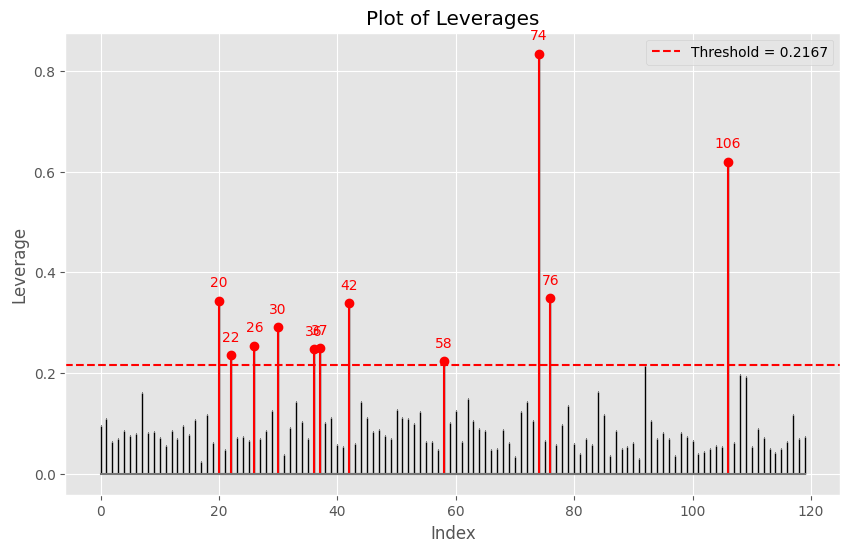

In [135]:
plt.figure(figsize=(10, 6))
stemlines, baseline, markerline = plt.stem(np.arange(len(leverage)), leverage, markerfmt=",")
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
plt.setp(markerline, markersize=5)
plt.setp(baseline, 'color', 'black', 'linewidth', 1)

for i in high_leverage_points:
    plt.annotate(i, (i, leverage[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

high_stemlines = plt.stem(high_leverage_points, leverage[high_leverage_points], linefmt='r')
plt.setp(high_stemlines[0], 'color', 'red')

plt.axhline(y=threshold_leverage, color='r', linestyle='--', label=f'Threshold = {threshold_leverage:.4f}')
plt.xlabel('Index')
plt.ylabel("Leverage")
plt.title("Plot of Leverages")
plt.legend()
plt.show()

**Description of the Plot**

The x-axis shows the indeces of the data points, whereas the y-axis shows the value for the leverage of those data points.

The red dashed line shows the threshold. Therefore, values above that line are high-leverage points.

### 2.2 High-Influence Points

In order to diagnose points that have a high influence, we are using Cook's distance. The cut off value for high influence points is $\frac{4}{n}$.

In [136]:
cooks_d = influence.cooks_distance[0]
threshold = 4 / len(y)
high_influence_points = np.where(cooks_d > threshold)[0]
for i in high_influence_points:
    print(f"Index: {i}, Cook's Distance: {leverage[i]:.4f}")

Index: 12, Cook's Distance: 0.0850
Index: 20, Cook's Distance: 0.3440
Index: 22, Cook's Distance: 0.2353
Index: 27, Cook's Distance: 0.0693
Index: 34, Cook's Distance: 0.1033
Index: 35, Cook's Distance: 0.0695
Index: 36, Cook's Distance: 0.2479
Index: 74, Cook's Distance: 0.8342
Index: 76, Cook's Distance: 0.3485


We can see, that the data points 12, 20, 22, 27, 34, 34, 36. 74 and 76 are considered as high influential points.

Now, we want to visualize this result.

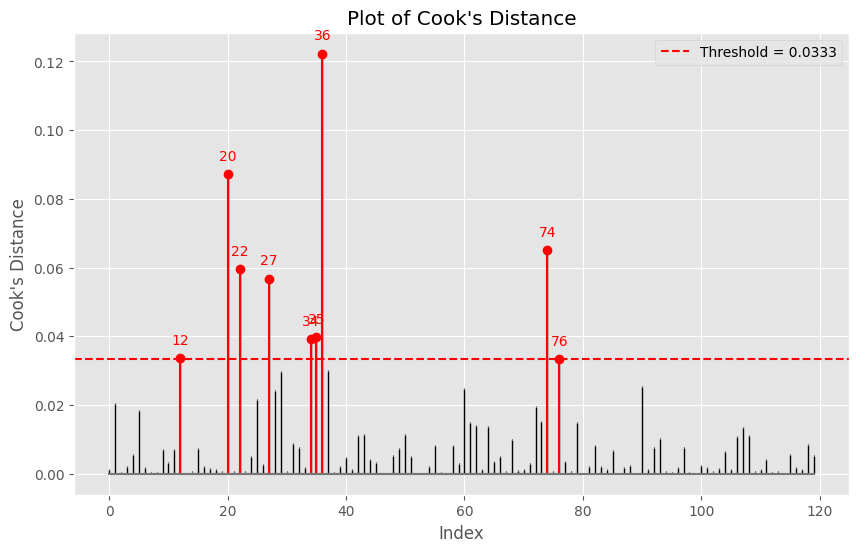

In [137]:
plt.figure(figsize=(10, 6))
stemlines, baseline, markerline = plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
plt.setp(markerline, markersize=5)
plt.setp(baseline, 'color', 'black', 'linewidth', 1)

for i in high_influence_points:
    plt.annotate(i, (i, cooks_d[i]), textcoords="offset points", xytext=(0,10), ha='center', color='red')

high_stemlines = plt.stem(high_influence_points, cooks_d[high_influence_points], linefmt='r')
plt.setp(high_stemlines[0], 'color', 'red')

plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.xlabel('Index')
plt.ylabel("Cook's Distance")
plt.title("Plot of Cook's Distance")
plt.legend()
plt.show()

**Description of the Plot**

The x-axis shows the indeces of the data points, whereas the y-axis shows the Cook's distance of those data points.

The red dashed line shows the threshold. Therefore, values above that line are high-influential points.

In [141]:
intersection_points = np.intersect1d(high_leverage_points, high_influence_points)
print(intersection_points)

[20 22 36 74 76]


**Interpretation**

After identifying points that have a high leverage and a high cook's distance we can conclude the points that have a high influence on the estimations.

Those points are **20, 22, 36, 74** and **76**.

___

## 3. Non-Linearity

One of the assumptions that were made for the multiple linear regression is the assumption of linearity. Now we want to check if the given data violate this assumption.

Linearity means that there is a linear relationship between our dependent variable 'stem_diameter' and the independent variables.

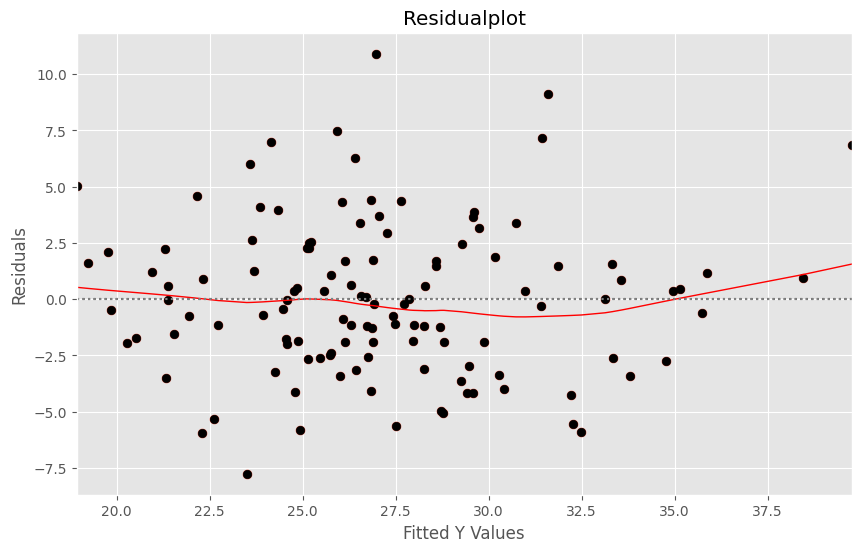

In [158]:
import seaborn as sns

predictions = model.predict(x)
residuals = y - predictions

# Residuenplot erstellen
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1, 'linestyle': '-'})
plt.scatter(predictions, residuals, color='black')
plt.axhline(y=0, color='gray', linestyle=':')
plt.xlabel('Fitted Y Values')
plt.ylabel('Residuals')
plt.title('Residualplot')
plt.show()

**Description of the Plot**

The plot shows the residuals on the y-axis versus the fitted values from the model on the x-axis.

The dotted gray line represents the zero residuals line. Points near the line indicate that the prediction of the model are close to the actual values.

The red line is a smoothed line that visualizes the trend of the residuals.

**Interpretation**

The residuals should be randomly distributed around the zero line if the model is correct. Here, you can see that the residuals are randomly distributed. This can be observed from the red line, as it is always close to the dotted line.

We would say that the linearity assumption is not violated. Now we want to show this in a statistical test. For that we are using the *Rainbow-Test*.

**Rainbow-Test**

This test assesses whether the linearity assumption is violated is the Rainbow Test.

The null hypothesis is that the relationship is linear, so we would suggest that p-values over 0.05 would cause us to reject the null hypothesis.

The 0.05 p-value threshold is a historical convention that provides a practical balance between the risks of Type I and Type II errors for different types of tests (Literature: Regression (Fahrmeir)).

In [159]:
from statsmodels.stats.diagnostic import linear_rainbow

rainbow_test = linear_rainbow(model)
print('Rainbow Test F-statistic: ', rainbow_test[0])
print('Rainbow Test p-value: ', rainbow_test[1])

Rainbow Test F-statistic:  1.2047811890762379
Rainbow Test p-value:  0.2549722679171801


**Interpretation**

As we get 0.25 as a p-value, we cannot reject the null hypothesis. We would suggest that the assumption of linearity is not violated.

___

## 4. Heteroscedasticity

The homoscedasticity is the assumption in the model that the variance of residuals is constant. If this assumption is violated (heteroscedasticity), the standard errors of the coefficients can be biased.